# Part B: Transfer Learning

Author _Thirada Tiamklang_

In Part B, your task is to pick the best pre-trained model from part A and fine-tune it on the Food101 Dataset.

Based on the results obtained in Part A, NasNet emerges as the top-performing model following by MobileNet V3. However, due to GPU runtime limitations, we will utilize MobileNet V3 instead of NasNet for fine-tuning in this phase

## 1. Loading and Explore Dataset

In [15]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [16]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

resize the images with the same as Part A which is 224x224 pixels.

In [17]:
image_size = 224 
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images while maintaining aspect ratio
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [18]:
# Define the root directory where the Food101 dataset images are located
data_dir = '/Users/thiradatiamklang/Desktop/DL/AT2/food-101/images'
# Create the full dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

## 2. Preparing Dataset

We will sample the dataset the same as part A which is six percent

In [19]:
sample_size = 0.06
data_size = len(full_dataset)
indices = list(range(data_size))
sample_indices = torch.randperm(data_size)[:int(sample_size*data_size)]

In [20]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [21]:
# Split indices into training and combined validation/test indices
train_indices, test_val_indices = train_test_split(range(len(sample_indices)), test_size=(val_ratio + test_ratio), random_state=42)

# Split combined validation/test indices into separate validation and test indices
val_indices, test_indices = train_test_split(test_val_indices, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)

train_set = Subset(full_dataset, train_indices)  # Subset for training data
val_set = Subset(full_dataset, val_indices)      # Subset for validation data
test_set = Subset(full_dataset, test_indices)    # Subset for test data

# Define the batch size
batch_size = 20  
# Create DataLoader instances for train, validation, and test sets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Print sizes of datasets
print("Training set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))

Training set size: 4242
Validation set size: 909
Test set size: 909


## 3. Fine-tuning

Now we will fine-tune the NasNet model with the same architecture as Part A but unfreezing the specified layers on two different epochs.

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

__[1.] CNN Model Architecture__

We will fine-tunes the NASNet model on the Food101 dataset for 10 epochs, experimenting with unfreezing different layers at layer 12 and 14.

In [25]:
# Load the pre-trained MobileNetV3 model
mobilenet_v3 = models.mobilenet_v3_large(pretrained=True)

# Define the number of input features for the fully connected layer
num_ftrs = mobilenet_v3.classifier[-1].in_features
num_classes = 101

mobilenet_v3.classifier = nn.Sequential(
            nn.Linear(960, 512),  # First fully connected layer
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),       # Second fully connected layer
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)  # Final fully connected layer for predictions
        )
mobile_tuned_model = mobilenet_v3

# Unfreeze specific layers
unfreeze_layers = [mobile_tuned_model.features[12], mobile_tuned_model.features[14]]  
for layer in unfreeze_layers:
    for param in layer.parameters():
        param.requires_grad = True

# Print the tuned MobileNet V3 model
print(mobile_tuned_model)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer_mobile = optim.Adam(mobile_tuned_model.parameters(), lr=0.00001)

In [27]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=5, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

In [28]:
custom_callback = CustomCallback()
custom_callback.set_optimizer(optimizer_mobile)
mobile_tuned_model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [29]:
lr_scheduler = ReduceLROnPlateau(optimizer_mobile, mode='min', factor=0.1, patience=3, min_lr=1e-6)
custom_callback.set_model(mobile_tuned_model)

__[2.] Train and Evaluation Model__

In [30]:
# Initialize lists to store epoch-wise values
train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies
val_losses = []  # List to store validation losses
val_accuracies = []  # List to store validation accuracies

# Training loop
num_epochs = 10  # Number of epochs for training
for epoch in range(num_epochs):
    # Training
    mobile_tuned_model.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer_mobile.zero_grad()  # Zero the parameter gradients
        outputs = mobile_tuned_model(inputs)  # Forward pass
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits if model returns tuple
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer_mobile.step()  # Optimize parameters

        running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        total_train += labels.size(0)  # Increment total training samples
        correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    mobile_tuned_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = mobile_tuned_model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(val_loader.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/10], Train Loss: 4.0100, Train Accuracy: 0.2480, Val Loss: 2.7796, Val Accuracy: 0.3091
Epoch [2/10], Train Loss: 1.9549, Train Accuracy: 0.4477, Val Loss: 1.3406, Val Accuracy: 0.6480
Epoch [3/10], Train Loss: 1.1671, Train Accuracy: 0.6754, Val Loss: 0.9457, Val Accuracy: 0.7470
Epoch [4/10], Train Loss: 0.8622, Train Accuracy: 0.7445, Val Loss: 0.7357, Val Accuracy: 0.7877
Epoch [5/10], Train Loss: 0.7070, Train Accuracy: 0.7881, Val Loss: 0.6085, Val Accuracy: 0.8097
Epoch [6/10], Train Loss: 0.5703, Train Accuracy: 0.8182, Val Loss: 0.5350, Val Accuracy: 0.8218
Epoch [7/10], Train Loss: 0.5065, Train Accuracy: 0.8322, Val Loss: 0.4799, Val Accuracy: 0.8427
Epoch [8/10], Train Loss: 0.4419, Train Accuracy: 0.8571, Val Loss: 0.4464, Val Accuracy: 0.8471
Epoch [9/10], Train Loss: 0.3966, Train Accuracy: 0.8656, Val Loss: 0.4233, Val Accuracy: 0.8592
Epoch [10/10], Train Loss: 0.3502, Train Accuracy: 0.8777, Val Loss: 0.4055, Val Accuracy: 0.8625


In [31]:
# Evaluation for test data
mobile_tuned_model.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs =  mobile_tuned_model(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.4116, Test Accuracy: 0.8658


__[3.] Analysing results__

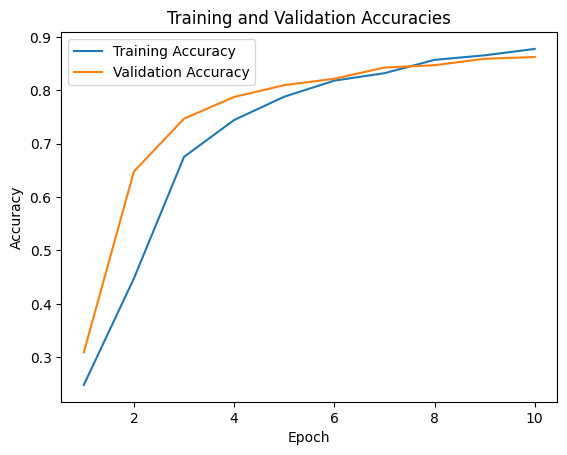

In [32]:
import matplotlib.pyplot as plt

# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

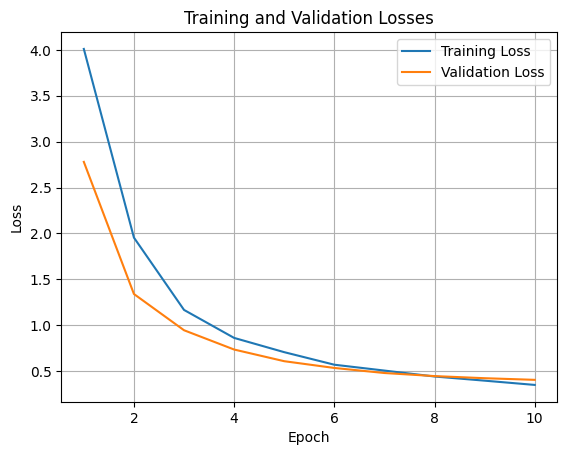

In [33]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot